In [241]:
import pandas as pd
import string
import matplotlib.pyplot as plt
import numpy as np
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
from gensim.models import Word2Vec
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Set up stop words and lemmatizer
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# Configuration variables
NUMBER_OF_UNIQUE_WORDS = 100
MAX_ITER_VALUE = 2000


# Function to preprocess text
def preprocess_text(text):
    if not isinstance(text, str):
        return ""

    # Convert text to lowercase and remove punctuation
    text = text.lower().translate(str.maketrans("", "", string.punctuation))

    # Tokenize and remove stop words and non-alphabetic words, then lemmatize
    words = [
        lemmatizer.lemmatize(word)
        for word in word_tokenize(text)
        if word not in stop_words and word.isalpha()
    ]
    return " ".join(words)


# Function to remove repeated words based on a threshold
def remove_repeated_words(text, threshold=3):
    words = text.split()
    filtered_words = []
    previous_word = None
    repeat_count = 0

    for word in words:
        if word == previous_word:
            repeat_count += 1
        else:
            repeat_count = 0

        if repeat_count < threshold:
            filtered_words.append(word)

        previous_word = word

    return " ".join(filtered_words)


# Function to replace game names in review text with the word 'game'
def replace_game_name(row):
    game_name_words = row["game_name"].lower().split()
    review_text = row["cleaned_review"].lower()
    for word in game_name_words:
        review_text = re.sub(re.escape(word), "game", review_text)
    return review_text


# Load datasets
def load_data():
    top_game_ids = pd.read_csv("./new_data/top_game_app_ids.csv")
    top_game_reviews = pd.read_csv("./new_data/top_game_app_ids_normalized_reviews.csv")
    worst_game_ids = pd.read_csv("./new_data/worst_game_app_ids.csv")
    worst_game_reviews = pd.read_csv(
        "./new_data/worst_game_app_ids_normalized_reviews.csv"
    )

    # Fill missing reviews with empty strings and remove duplicates
    for df in [top_game_reviews, worst_game_reviews]:
        df["review"] = df["review"].fillna("").astype(str)
        df.drop_duplicates(subset="review", inplace=True)

    return top_game_ids, top_game_reviews, worst_game_ids, worst_game_reviews


# Preprocess reviews
def preprocess_reviews(reviews_df):
    reviews_df["cleaned_review"] = reviews_df["review"].apply(preprocess_text)
    reviews_df["cleaned_review"] = reviews_df["cleaned_review"].apply(
        lambda x: remove_repeated_words(x, threshold=3)
    )
    reviews_df = reviews_df[reviews_df["cleaned_review"].str.strip() != ""]
    return reviews_df


# Execute text mining steps
top_game_ids, top_game_reviews, worst_game_ids, worst_game_reviews = load_data()

top_game_reviews = preprocess_reviews(top_game_reviews)
worst_game_reviews = preprocess_reviews(worst_game_reviews)

top_game_reviews = top_game_reviews.merge(top_game_ids, on="app_id", how="left")
worst_game_reviews = worst_game_reviews.merge(worst_game_ids, on="app_id", how="left")

top_game_reviews["cleaned_review"] = top_game_reviews.apply(replace_game_name, axis=1)
worst_game_reviews["cleaned_review"] = worst_game_reviews.apply(
    replace_game_name, axis=1
)

In [242]:
# Analýza sentimentu


analyzer = SentimentIntensityAnalyzer()


def analyze_sentiment(review):
    score = analyzer.polarity_scores(review)
    return score["compound"]


top_game_reviews["sentiment"] = top_game_reviews["cleaned_review"].apply(
    analyze_sentiment
)
worst_game_reviews["sentiment"] = worst_game_reviews["cleaned_review"].apply(
    analyze_sentiment
)

worst_game_reviews.head()

,app_id,review,cleaned_review,game_name,sentiment
0,1786200,the bad gameplay extremely easy once youve go...,bad gameplay extremely easy youve got gear eve...,Wars and Roses,0.2195
1,1786200,if you expect something like she will punish t...,expect something like punish modern setting di...,Wars and Roses,-0.9473
2,1786200,i feel like this game should have been early a...,feel like game early access ran many issuesbug...,Wars and Roses,0.4404
3,1786200,game is not bad the women are nice the sex is ...,game bad woman nice sex good even shooting mec...,Wars and Roses,0.9274
4,1786200,h1too long didnt read versionh1 table tr tdrec...,long didnt read table tr tdrecommendtd sale pa...,Wars and Roses,0.9895


In [243]:
# Extrakce klíčových slov
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
top_tfidf = vectorizer.fit_transform(top_game_reviews["cleaned_review"])
top_keywords = vectorizer.get_feature_names_out()

vectorizer = TfidfVectorizer(stop_words="english", max_features=100)
worst_tfidf = vectorizer.fit_transform(worst_game_reviews["cleaned_review"])
worst_keywords = vectorizer.get_feature_names_out()

top_keywords, worst_keywords

(array(['absolutely', 'access', 'actually', 'amazing', 'art', 'bad',
        'best', 'better', 'bit', 'bos', 'build', 'buy', 'change',
        'character', 'combat', 'come', 'content', 'day', 'design', 'didnt',
        'different', 'difficulty', 'doesnt', 'dont', 'early', 'easy',
        'end', 'enemy', 'enjoy', 'experience', 'far', 'feel', 'friend',
        'fun', 'game', 'gameplay', 'getting', 'going', 'good', 'got',
        'great', 'hard', 'hate', 'hour', 'im', 'interesting', 'isnt',
        'item', 'ive', 'know', 'level', 'life', 'like', 'little', 'long',
        'look', 'lot', 'love', 'make', 'mechanic', 'music', 'need', 'new',
        'nice', 'overall', 'people', 'play', 'played', 'player', 'playing',
        'point', 'pretty', 'price', 'puzzle', 'really', 'recommend',
        'review', 'right', 'run', 'say', 'start', 'story', 'style',
        'survival', 'thats', 'thing', 'think', 'time', 'try', 'unique',
        'use', 'want', 'way', 'weapon', 'work', 'world', 'worth', 'year',

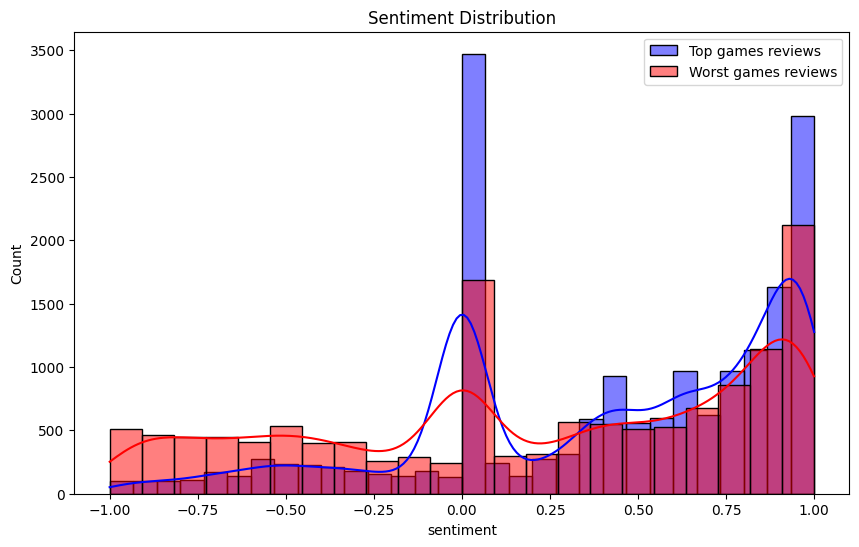

In [250]:
# Vizualizace sentimentu
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(top_game_reviews["sentiment"], color="blue", kde=True, label="Top games reviews")
sns.histplot(
    worst_game_reviews["sentiment"], color="red", kde=True, label="Worst games reviews"
)
plt.title("Sentiment Distribution")
plt.legend()
plt.show()

/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3419452165.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3419452165.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3419452165.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram',

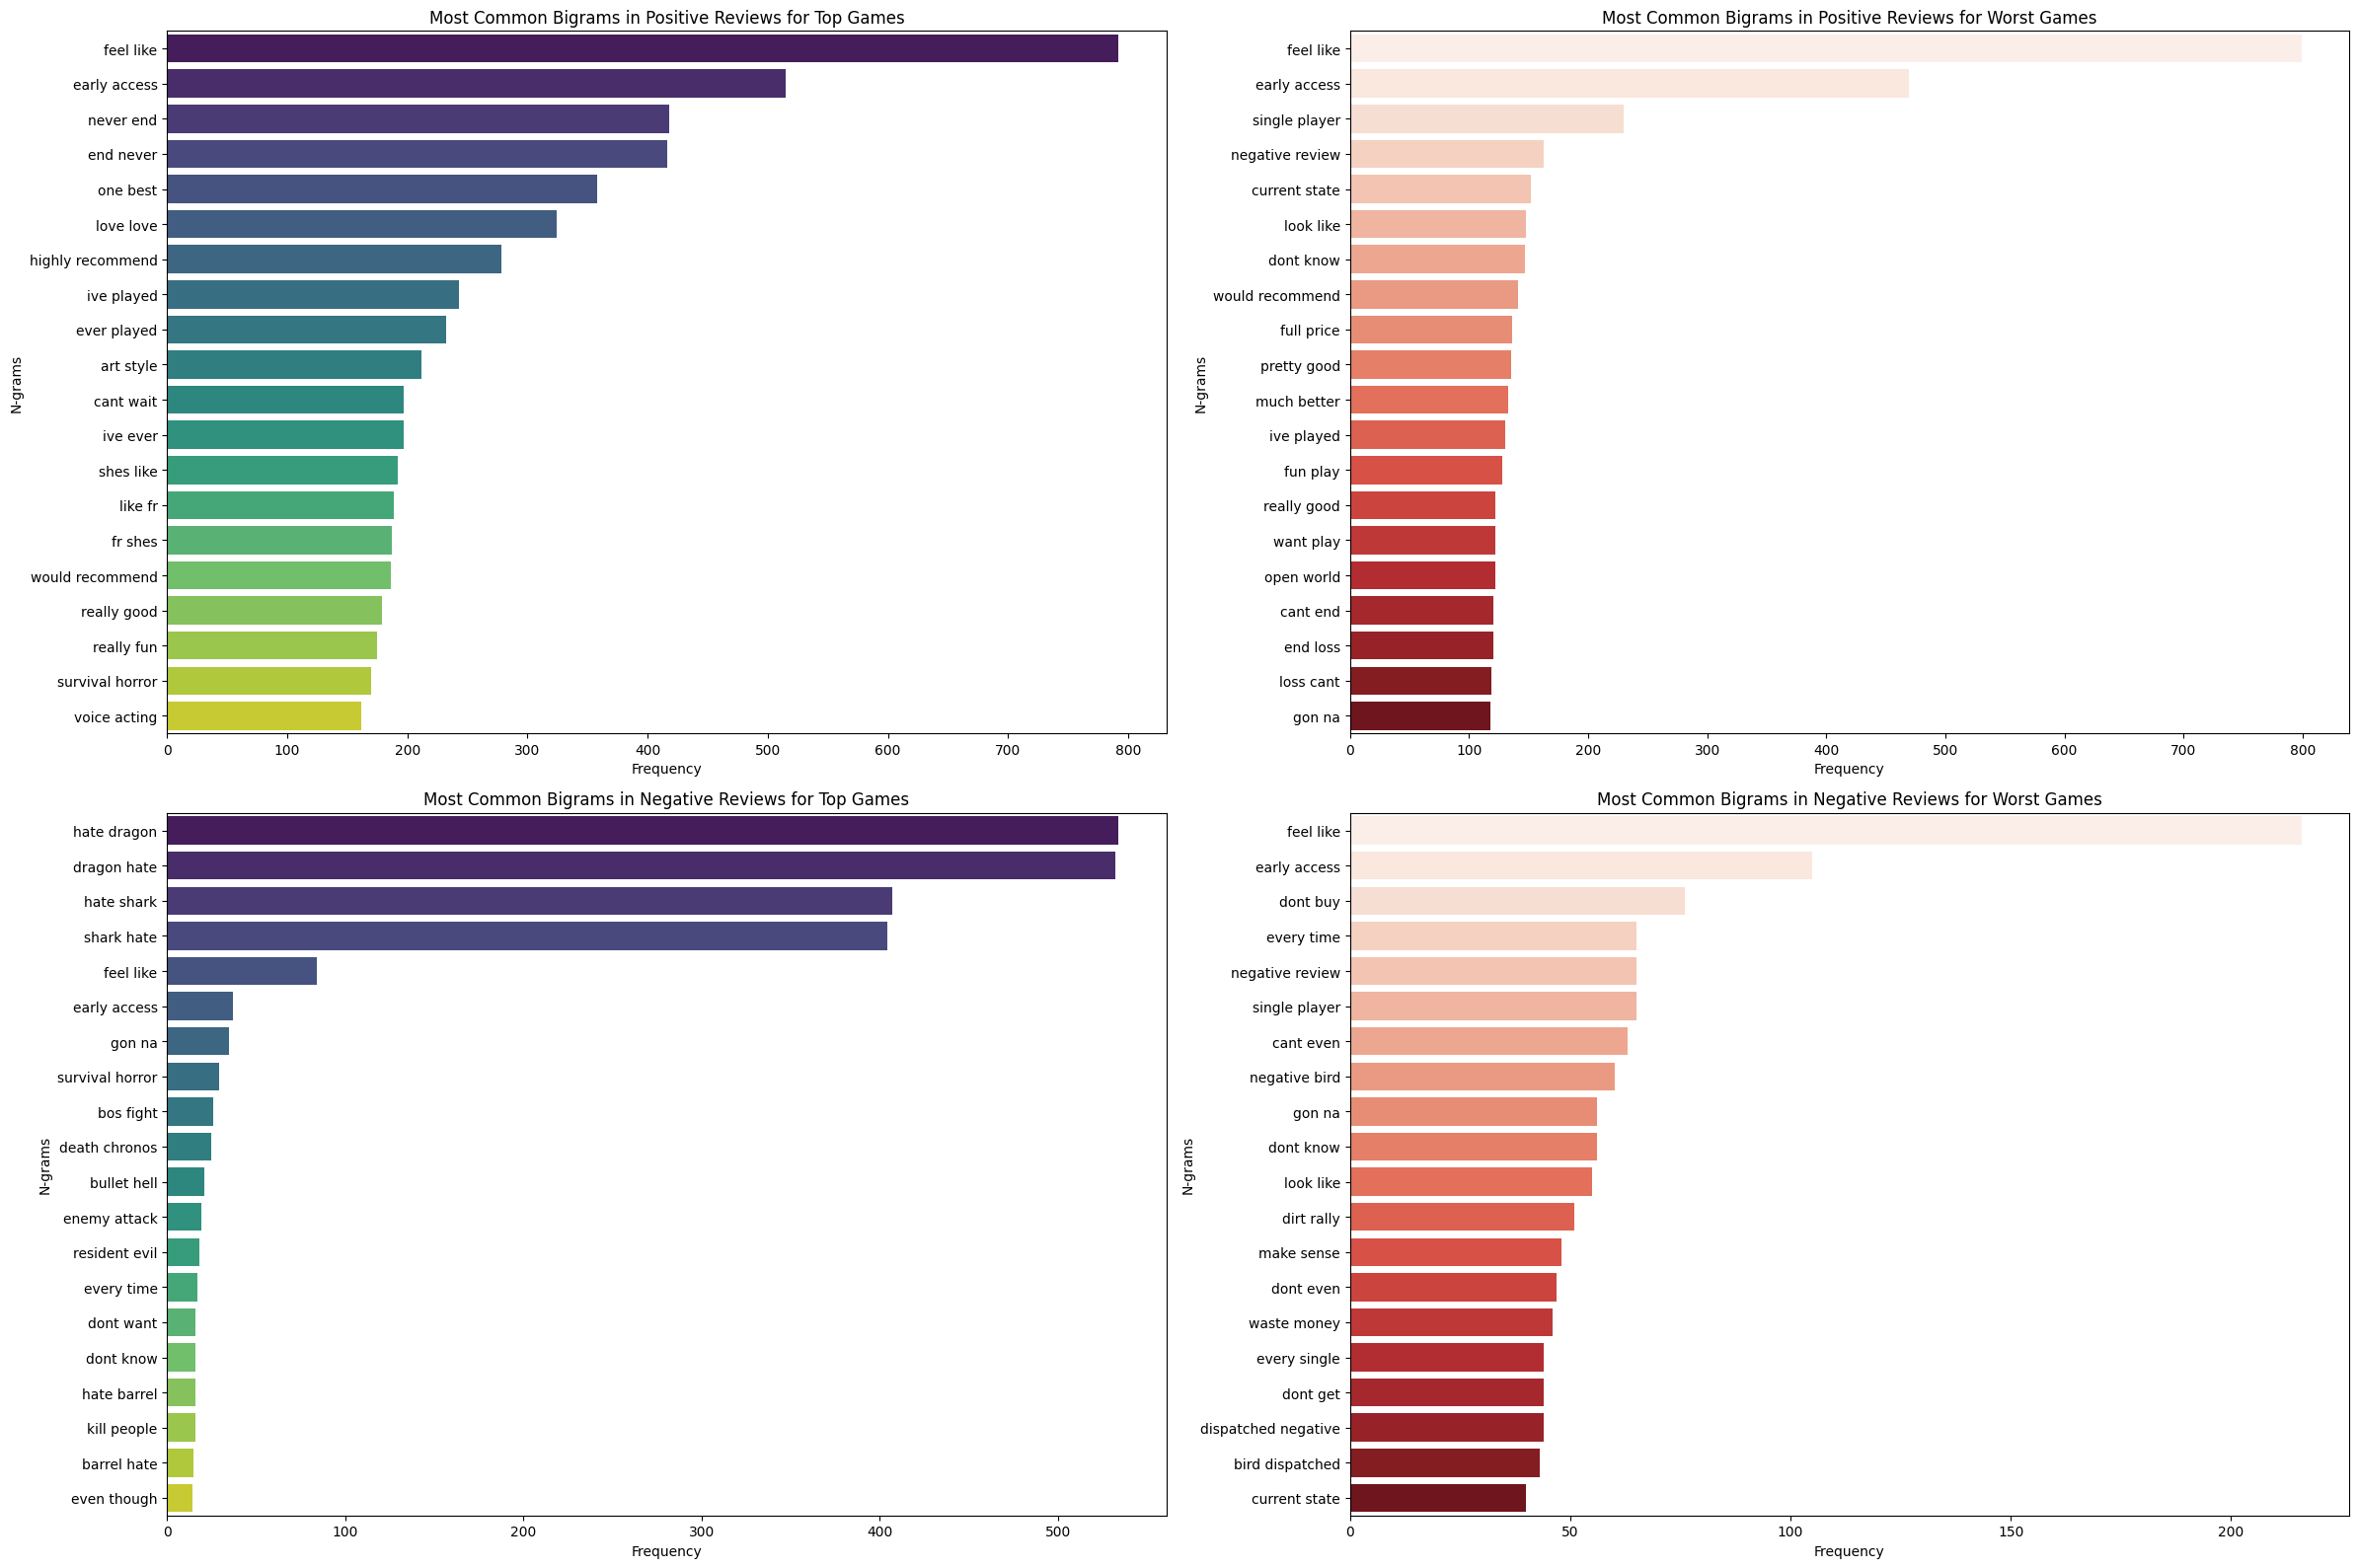

In [259]:
# Import necessary libraries for visualization and word counting
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt

# Filter for positive and negative reviews
positive_top_reviews = top_game_reviews[top_game_reviews["sentiment"] > 0.5]
negative_top_reviews = top_game_reviews[top_game_reviews["sentiment"] < -0.5]
positive_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] > 0.5]
negative_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] < -0.5]

# Function to get most common n-grams from reviews and exclude specified words
def get_most_common_ngrams(reviews, n=2, exclude_words=set(), top_n=20):
    all_text = " ".join(reviews["cleaned_review"])
    words = [word for word in all_text.split() if word not in exclude_words]
    n_grams = ngrams(words, n)
    ngram_counts = Counter(n_grams)
    return ngram_counts.most_common(top_n)

# Words to exclude
exclude_words = {"game"}

# Get most common bigrams (2-grams) for each category excluding "game"
most_common_positive_top = get_most_common_ngrams(positive_top_reviews, n=2, exclude_words=exclude_words)
most_common_negative_top = get_most_common_ngrams(negative_top_reviews, n=2, exclude_words=exclude_words)
most_common_positive_worst = get_most_common_ngrams(positive_worst_reviews, n=2, exclude_words=exclude_words)
most_common_negative_worst = get_most_common_ngrams(negative_worst_reviews, n=2, exclude_words=exclude_words)

# Function to create a bar plot for most common n-grams
def create_ngram_bar_plot(ax, common_ngrams, title, color_palette='viridis'):
    ngrams_df = pd.DataFrame(common_ngrams, columns=['N-gram', 'Count'])
    ngrams_df['N-gram'] = ngrams_df['N-gram'].apply(lambda x: ' '.join(x))
    sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-grams')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

# Create bar plots for bigrams
create_ngram_bar_plot(axs[0, 0], most_common_positive_top, 'Most Common Bigrams in Positive Reviews for Top Games')
create_ngram_bar_plot(axs[0, 1], most_common_positive_worst, 'Most Common Bigrams in Positive Reviews for Worst Games', color_palette='Reds')
create_ngram_bar_plot(axs[1, 0], most_common_negative_top, 'Most Common Bigrams in Negative Reviews for Top Games')
create_ngram_bar_plot(axs[1, 1], most_common_negative_worst, 'Most Common Bigrams in Negative Reviews for Worst Games', color_palette='Reds')

plt.tight_layout()
plt.show()


/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3427539454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3427539454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
/var/folders/7t/dzsnj9td6dj4y5v2x5c01dkh0000gn/T/ipykernel_17446/3427539454.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='N-gram',

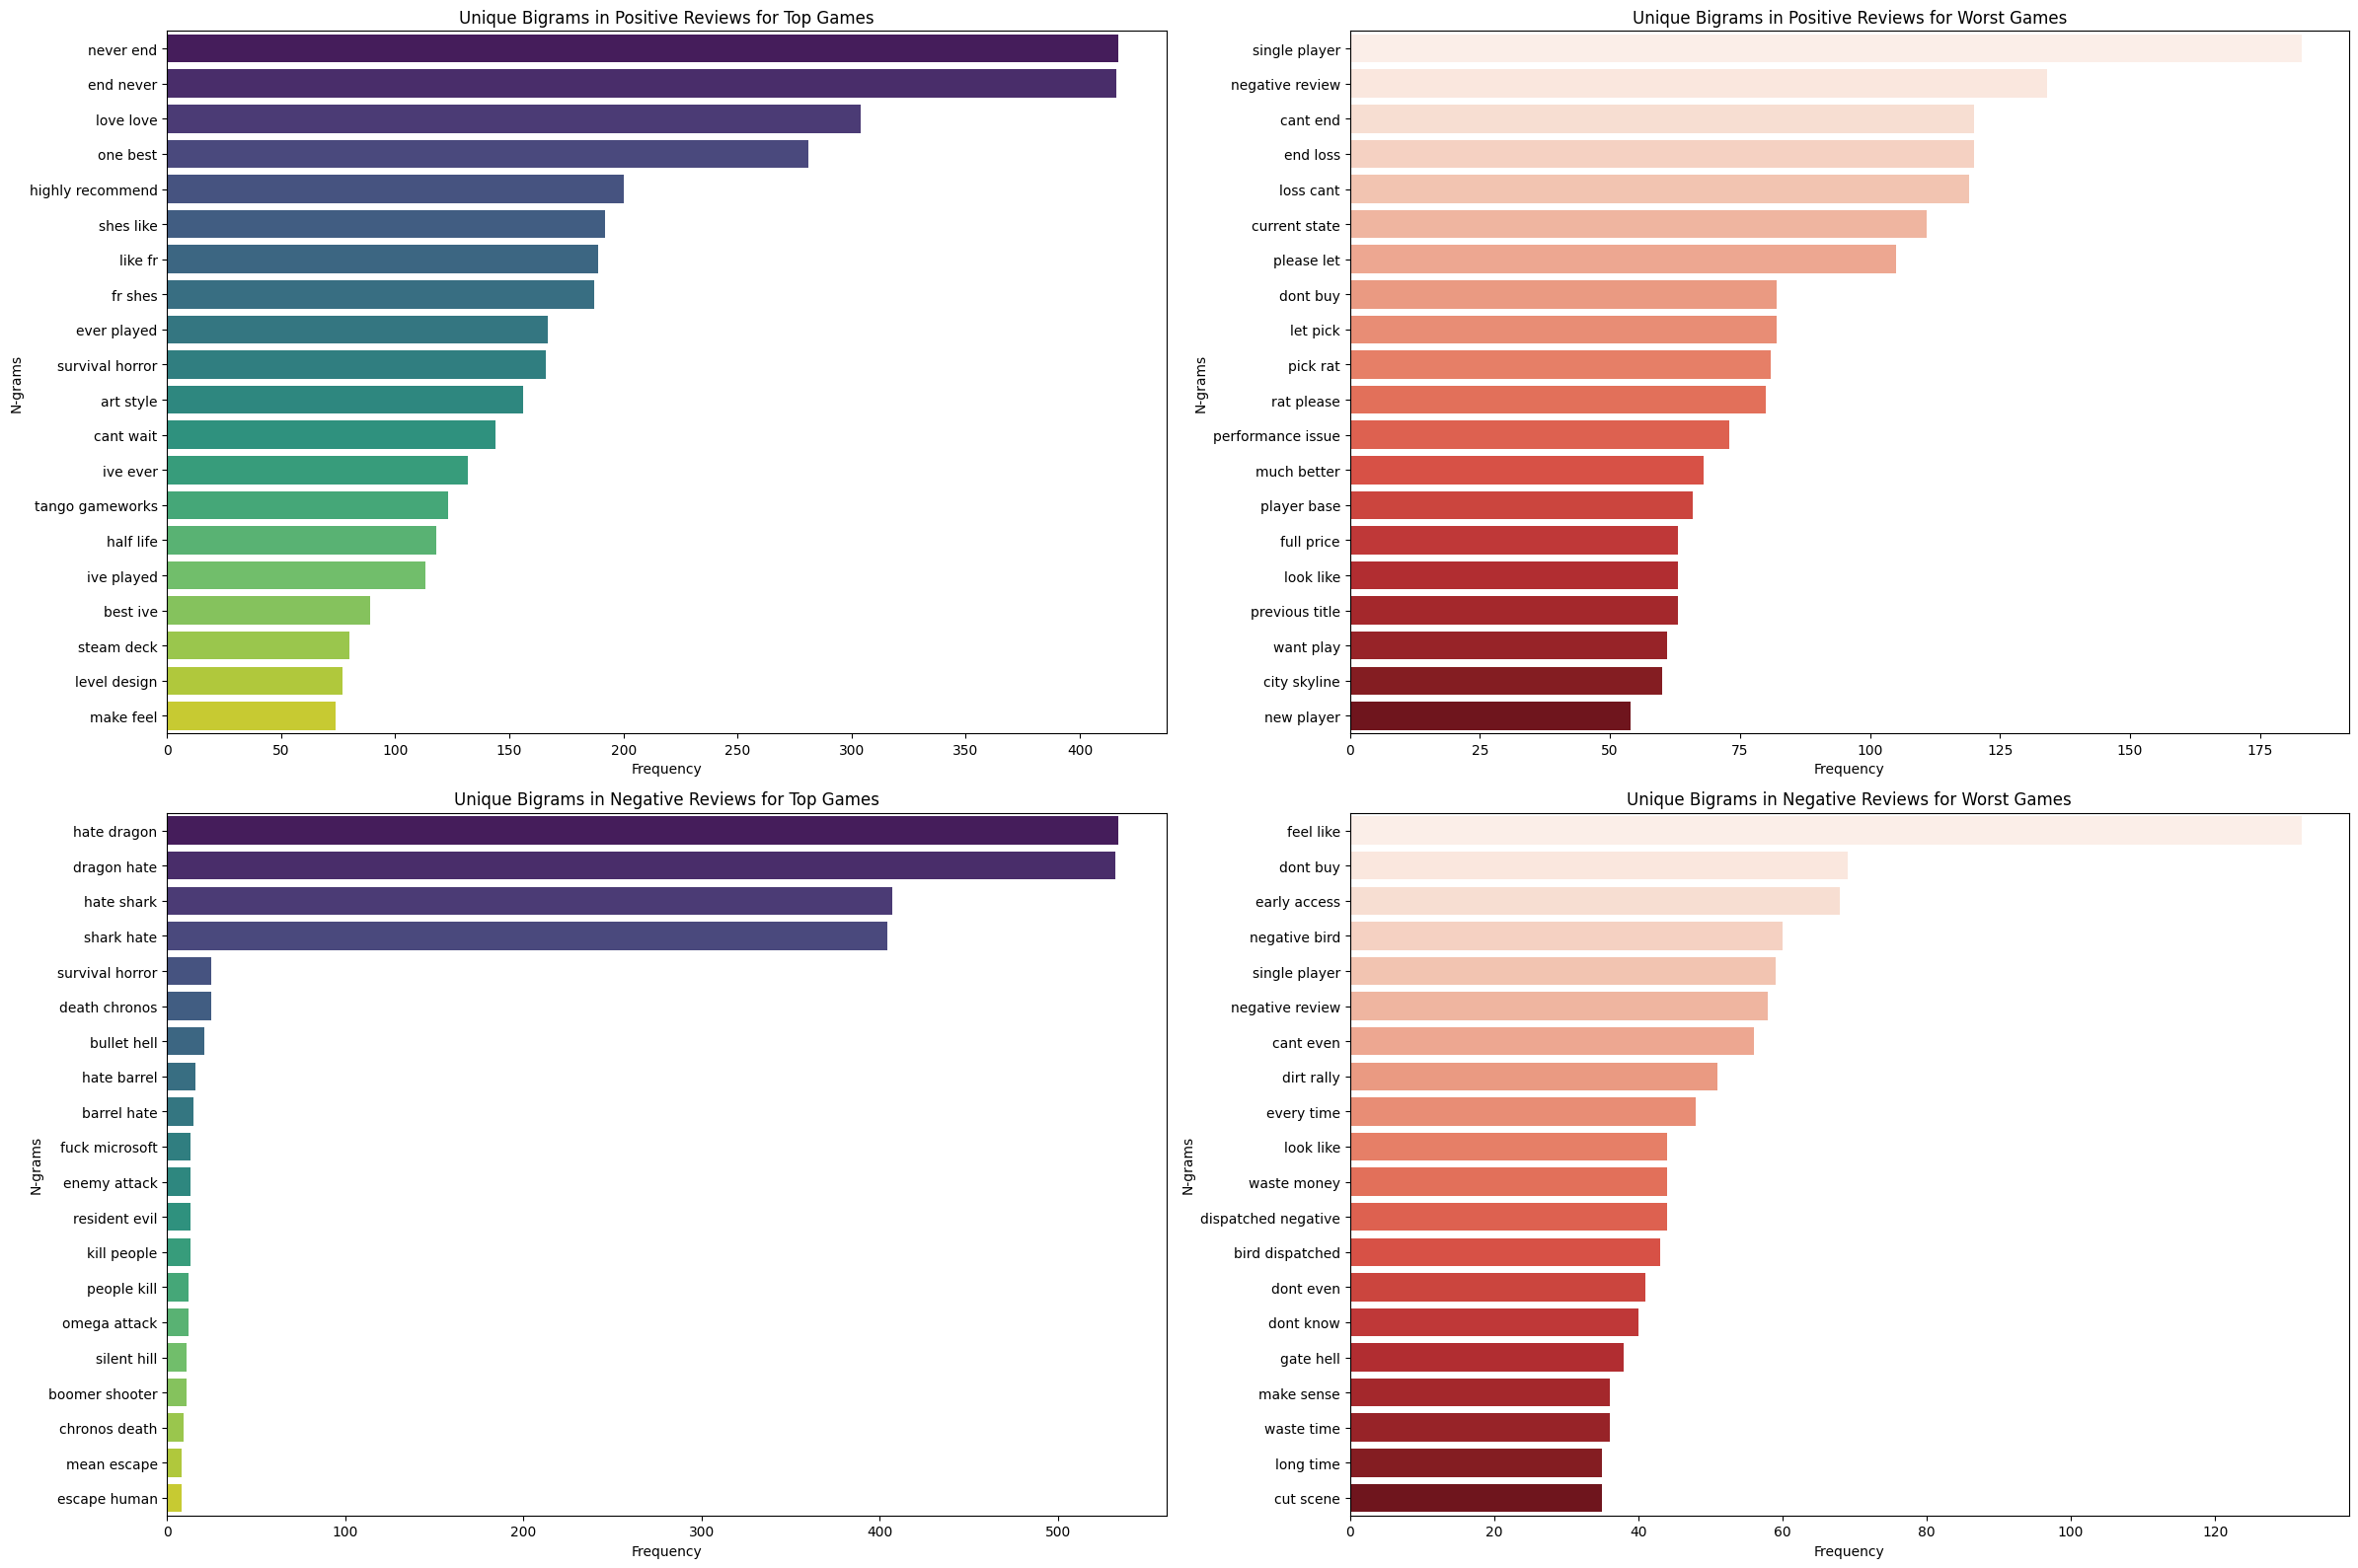

In [260]:
# Import necessary libraries for visualization and word counting
import seaborn as sns
from collections import Counter
from nltk.util import ngrams
import matplotlib.pyplot as plt

# Filter for positive and negative reviews
positive_top_reviews = top_game_reviews[top_game_reviews["sentiment"] > 0.5]
negative_top_reviews = top_game_reviews[top_game_reviews["sentiment"] < -0.5]
positive_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] > 0.5]
negative_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] < -0.5]

# Function to get most common n-grams from reviews and exclude specified words
def get_most_common_ngrams(reviews, n=2, exclude_words=set(), top_n=20):
    all_text = " ".join(reviews["cleaned_review"])
    words = [word for word in all_text.split() if word not in exclude_words]
    n_grams = ngrams(words, n)
    ngram_counts = Counter(n_grams)
    return ngram_counts

# Words to exclude
exclude_words = {"game"}

# Get most common bigrams (2-grams) for each category excluding "game"
positive_top_bigrams = get_most_common_ngrams(positive_top_reviews, n=2, exclude_words=exclude_words)
negative_top_bigrams = get_most_common_ngrams(negative_top_reviews, n=2, exclude_words=exclude_words)
positive_worst_bigrams = get_most_common_ngrams(positive_worst_reviews, n=2, exclude_words=exclude_words)
negative_worst_bigrams = get_most_common_ngrams(negative_worst_reviews, n=2, exclude_words=exclude_words)

# Function to get unique bigrams
def get_unique_bigrams(bigrams1, bigrams2, top_n=20):
    unique_bigrams = bigrams1 - bigrams2
    return unique_bigrams.most_common(top_n)

# Get unique bigrams
unique_positive_top_bigrams = get_unique_bigrams(positive_top_bigrams, positive_worst_bigrams)
unique_negative_top_bigrams = get_unique_bigrams(negative_top_bigrams, negative_worst_bigrams)
unique_positive_worst_bigrams = get_unique_bigrams(positive_worst_bigrams, positive_top_bigrams)
unique_negative_worst_bigrams = get_unique_bigrams(negative_worst_bigrams, negative_top_bigrams)

# Function to create a bar plot for unique n-grams
def create_ngram_bar_plot(ax, unique_ngrams, title, color_palette='viridis'):
    ngrams_df = pd.DataFrame(unique_ngrams, columns=['N-gram', 'Count'])
    ngrams_df['N-gram'] = ngrams_df['N-gram'].apply(lambda x: ' '.join(x))
    sns.barplot(x='Count', y='N-gram', data=ngrams_df, palette=color_palette, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('N-grams')

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(24, 16))

# Create bar plots for unique bigrams
create_ngram_bar_plot(axs[0, 0], unique_positive_top_bigrams, 'Unique Bigrams in Positive Reviews for Top Games')
create_ngram_bar_plot(axs[0, 1], unique_positive_worst_bigrams, 'Unique Bigrams in Positive Reviews for Worst Games', color_palette='Reds')
create_ngram_bar_plot(axs[1, 0], unique_negative_top_bigrams, 'Unique Bigrams in Negative Reviews for Top Games')
create_ngram_bar_plot(axs[1, 1], unique_negative_worst_bigrams, 'Unique Bigrams in Negative Reviews for Worst Games', color_palette='Reds')

plt.tight_layout()
plt.show()


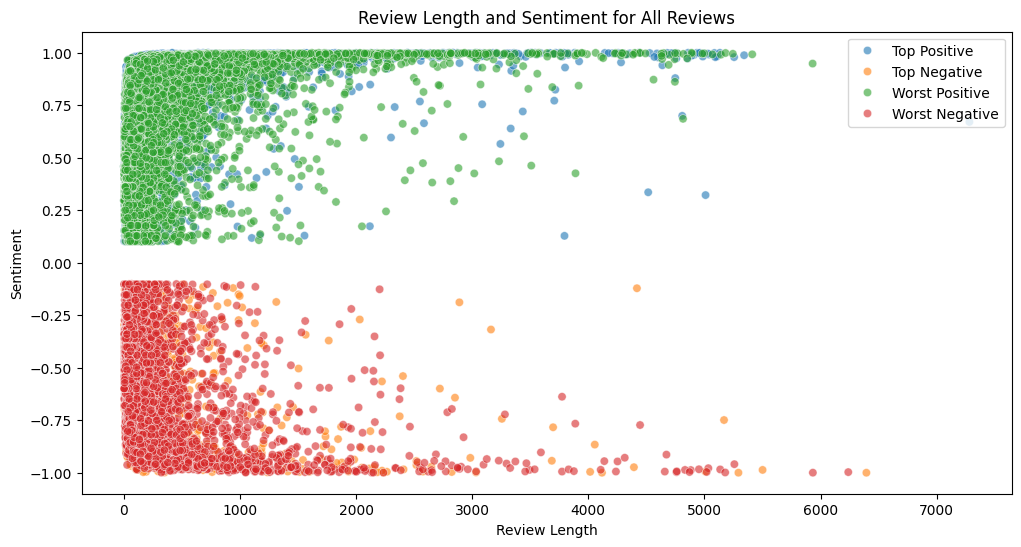

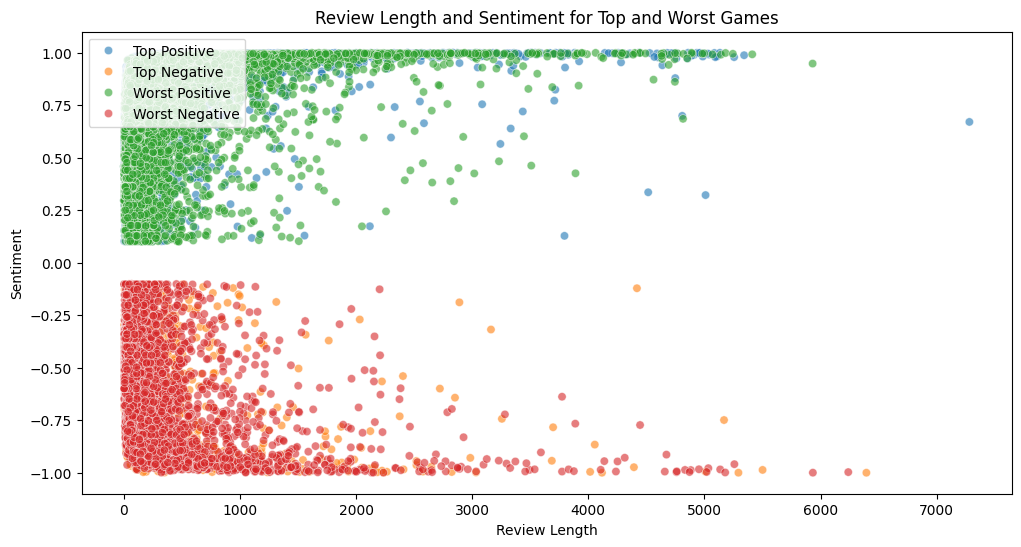

<Figure size 1200x600 with 0 Axes>

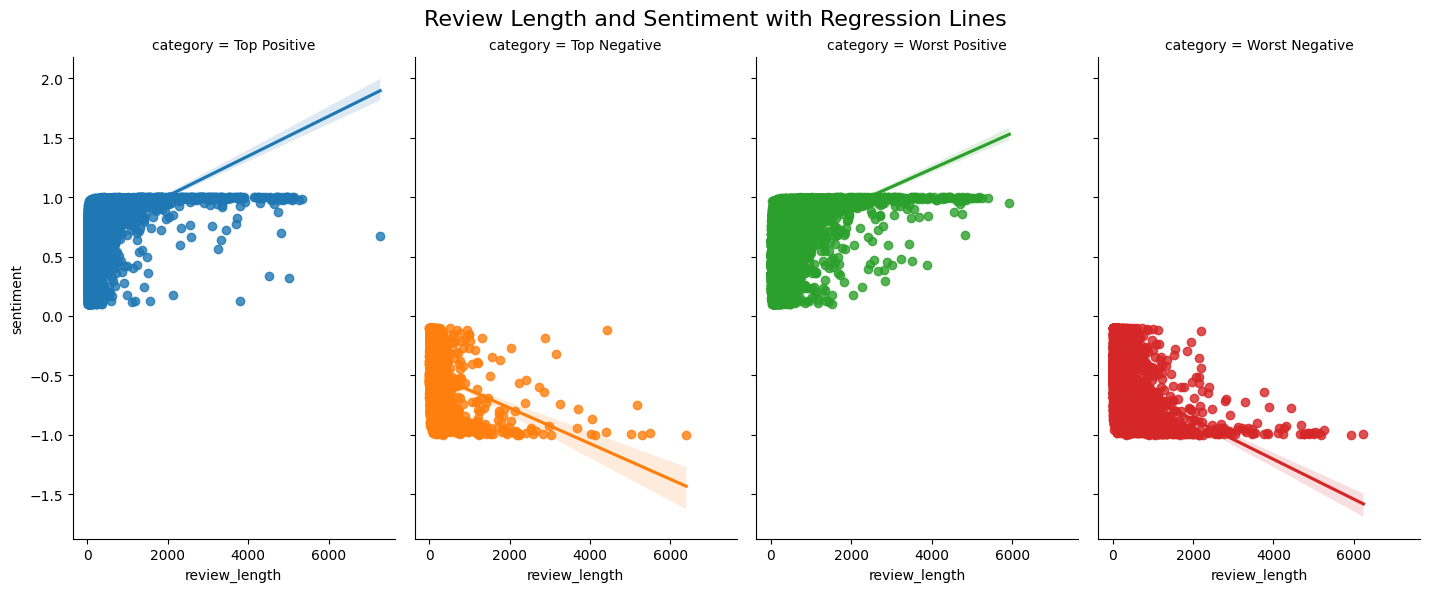

In [264]:
# Calculate the length of each review
top_game_reviews["review_length"] = top_game_reviews["cleaned_review"].apply(len)
worst_game_reviews["review_length"] = worst_game_reviews["cleaned_review"].apply(len)

# Separate positive and negative reviews
positive_reviews = top_game_reviews[top_game_reviews["sentiment"] > 0.1]
negative_reviews = top_game_reviews[top_game_reviews["sentiment"] < -0.1]
positive_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] > 0.1]
negative_worst_reviews = worst_game_reviews[worst_game_reviews["sentiment"] < -0.1]

# Combine positive and negative reviews from top and worst games
combined_reviews = pd.concat([
    positive_reviews.assign(category="Top Positive"),
    negative_reviews.assign(category="Top Negative"),
    positive_worst_reviews.assign(category="Worst Positive"),
    negative_worst_reviews.assign(category="Worst Negative")
])

# Scatter plot for all positive and negative reviews
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_reviews, x="review_length", y="sentiment", hue="category", alpha=0.6)
plt.title("Review Length and Sentiment for All Reviews")
plt.xlabel("Review Length")
plt.ylabel("Sentiment")
plt.legend(loc='upper right')
plt.show()

# Scatter plot for positive and negative reviews for top and worst games
plt.figure(figsize=(12, 6))
sns.scatterplot(data=combined_reviews, x="review_length", y="sentiment", hue="category", alpha=0.6)
plt.title("Review Length and Sentiment for Top and Worst Games")
plt.xlabel("Review Length")
plt.ylabel("Sentiment")
plt.legend(loc='upper left')
plt.show()

# Additional analysis with regression lines
plt.figure(figsize=(12, 6))
sns.lmplot(data=combined_reviews, x="review_length", y="sentiment", hue="category", col="category", aspect=0.6, height=6)
plt.subplots_adjust(top=0.9)
plt.suptitle("Review Length and Sentiment with Regression Lines", fontsize=16)
plt.show()


100 most frequency words (word, frequency):
 [('game', 67718), ('like', 12935), ('get', 8508), ('time', 8169), ('good', 7437), ('one', 7374), ('play', 7194), ('fun', 6456), ('even', 6279), ('really', 6231), ('feel', 6209), ('dont', 5644), ('make', 5436), ('would', 4876), ('story', 4795), ('much', 4725), ('great', 4491), ('also', 4284), ('thing', 4268), ('still', 4255), ('first', 4182), ('way', 4091), ('im', 4076), ('lot', 3972), ('never', 3964), ('hour', 3799), ('new', 3753), ('love', 3712), ('end', 3681), ('character', 3599), ('player', 3463), ('want', 3386), ('playing', 3358), ('need', 3355), ('better', 3315), ('go', 3291), ('gameplay', 3240), ('every', 3204), ('well', 3177), ('people', 3062), ('cant', 3020), ('played', 2951), ('see', 2851), ('could', 2805), ('many', 2746), ('bad', 2719), ('think', 2711), ('ive', 2648), ('review', 2623), ('recommend', 2619), ('best', 2513), ('experience', 2482), ('issue', 2478), ('buy', 2451), ('take', 2434), ('made', 2422), ('look', 2367), ('run', 2

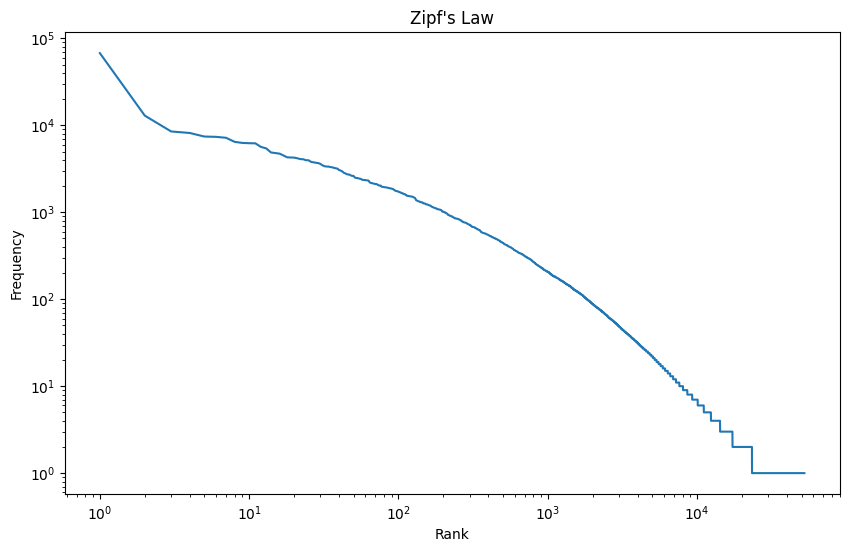

Top 10 Bigrams in Best Reviews: [(('game', 'game'), 2549), (('never', 'end'), 1768), (('end', 'never'), 1765), (('feel', 'like'), 970), (('love', 'game'), 728), (('early', 'access'), 645), (('first', 'game'), 615), (('game', 'like'), 549), (('hate', 'dragon'), 534), (('dragon', 'hate'), 532), (('great', 'game'), 485), (('good', 'game'), 481), (('game', 'love'), 466), (('play', 'game'), 445), (('like', 'game'), 438), (('hate', 'shark'), 407), (('shark', 'hate'), 404), (('one', 'best'), 382), (('game', 'play'), 364), (('best', 'game'), 352), (('fun', 'game'), 351), (('game', 'ive'), 334), (('playing', 'game'), 326), (('game', 'really'), 317), (('highly', 'recommend'), 303), (('recommend', 'game'), 290), (('game', 'good'), 290), (('ive', 'played'), 271), (('game', 'ever'), 264), (('ever', 'played'), 260), (('cant', 'wait'), 255), (('game', 'one'), 249), (('game', 'great'), 247), (('amazing', 'game'), 244), (('survival', 'horror'), 242), (('ive', 'ever'), 237), (('would', 'recommend'), 236

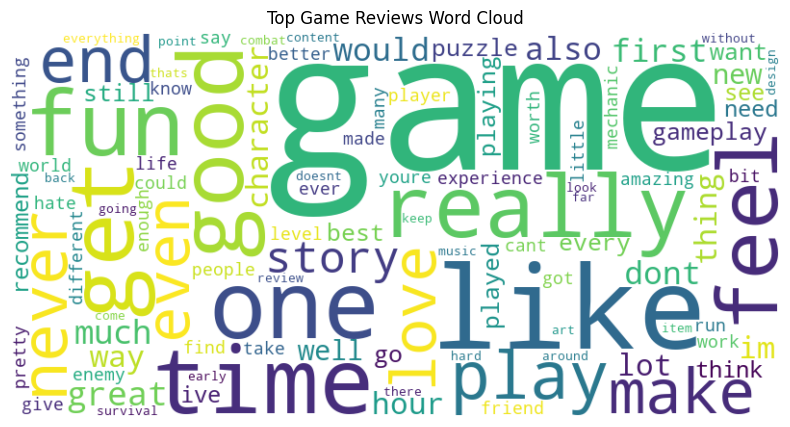

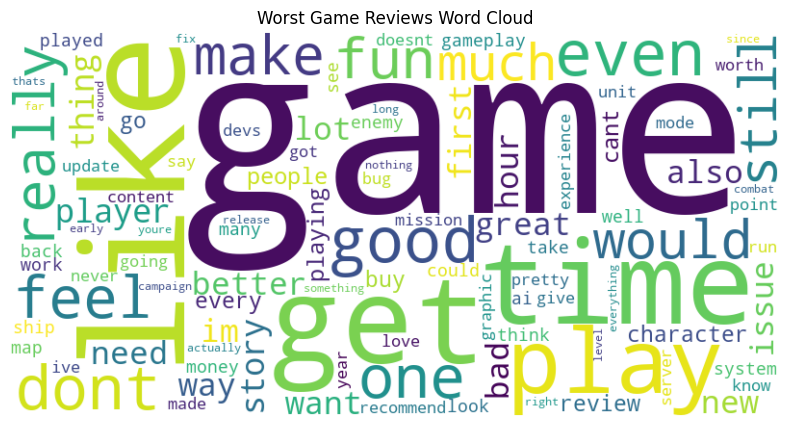

In [ ]:
# Analýza recenzí
from nltk.util import ngrams


# funkce pro vizualizaci dat pomocí grafu word cloud (slovní mraky)
def plot_word_cloud(word_freq, title, max_words=None):
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", max_words=max_words
    )
    wordcloud.generate_from_frequencies(dict(word_freq))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(title)
    plt.axis("off")
    plt.show()


# Kontrola frekvence slov a odstranění duplicit
def get_most_common_words(texts, max_words=None):
    all_text = " ".join(texts)
    words = all_text.split()
    most_common_words = Counter(words).most_common(max_words)
    return most_common_words


# funkce pro vytvoření slovníku
def build_word_frequency(texts):
    all_words = " ".join(texts).split()
    word_freq = Counter(all_words)
    return word_freq


# funkce pro vytvoření grafu Zipova zákona
def plot_zipf(word_freq):
    freqs = [freq for word, freq in word_freq.most_common()]
    ranks = range(1, len(freqs) + 1)
    plt.figure(figsize=(10, 6))
    plt.plot(ranks, freqs)
    plt.yscale("log")
    plt.xscale("log")
    plt.title("Zipf's Law")
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.show()


# funkce pro generování n-gramu
def generate_ngrams(text, n):
    words = text.split()
    return list(ngrams(words, n))


def build_ngram_frequency(texts, n):
    all_ngrams = []
    for text in texts:
        n_grams = generate_ngrams(text, n)
        all_ngrams.extend(n_grams)
    ngram_freq = Counter(all_ngrams)
    return ngram_freq


# Kombinace textů
all_reviews_text = pd.concat(
    [top_game_reviews["cleaned_review"], worst_game_reviews["cleaned_review"]]
)

# Vytvoření slovníku frekvence slov
word_freq = build_word_frequency(all_reviews_text)
print(
    "100 most frequency words (word, frequency):\n", word_freq.most_common(100)
)  # Zobrazení 10 nejčastějších slov

# Vytvoření grafu Zipova zákona:
plot_zipf(word_freq)

# proměnná pro počet n-gramů
number_of_ngram = 100

# Předzpracované texty pro nejlepší recenze
best_reviews_text = top_game_reviews["cleaned_review"].tolist()
worst_reviews_text = worst_game_reviews["cleaned_review"].tolist()

# Vytvoření frekvenčních slovníků pro bigramy a trigramy pro nejlepší recenze
best_bigram_freq = build_ngram_frequency(best_reviews_text, 2)
best_trigram_freq = build_ngram_frequency(best_reviews_text, 3)

# Zobrazení 10 nejčastějších bigramů a trigramů pro nejlepší recenze
print("Top 10 Bigrams in Best Reviews:", best_bigram_freq.most_common(number_of_ngram))
print(
    "Top 10 Trigrams in Best Reviews:", best_trigram_freq.most_common(number_of_ngram)
)

# Vytvoření frekvenčních slovníků pro bigramy a trigramy pro nejhorší recenze
worst_bigram_freq = build_ngram_frequency(worst_reviews_text, 2)
worst_trigram_freq = build_ngram_frequency(worst_reviews_text, 3)

# Zobrazení 10 nejčastějších bigramů a trigramů pro nejhorší recenze
print(
    "Top 10 Bigrams in Worst Reviews:", worst_bigram_freq.most_common(number_of_ngram)
)
print(
    "Top 10 Trigrams in Worst Reviews:", worst_trigram_freq.most_common(number_of_ngram)
)


# Vytvoření frekvenčních slovníků pro bigramy a trigramy pro všechny recenze
all_bigram_freq = build_ngram_frequency(all_reviews_text, 2)
all_trigram_freq = build_ngram_frequency(all_reviews_text, 3)

# Zobrazení 10 nejčastějších bigramů a trigramů pro všechny recenze
print("Top 100 Bigrams in All Reviews:", all_bigram_freq.most_common(number_of_ngram))
print("Top 100 Trigrams in All Reviews:", all_trigram_freq.most_common(number_of_ngram))

# Vytvoření seznamů nejčastějších slov pro nejlepší a nejhorší recenze
best_reviews_common_text = get_most_common_words(
    best_reviews_text, max_words=NUMBER_OF_UNIQUE_WORDS
)
worst_reviews_common_text = get_most_common_words(
    worst_reviews_text, max_words=NUMBER_OF_UNIQUE_WORDS
)

# Zobrazení nejčastějších slov
print("Most common words in best reviews:", best_reviews_common_text)
print("Most common words in worst reviews:", worst_reviews_common_text)

# Generování a zobrazení word cloud
plot_word_cloud(
    best_reviews_common_text,
    "Top Game Reviews Word Cloud",
    max_words=NUMBER_OF_UNIQUE_WORDS,
)
plot_word_cloud(
    worst_reviews_common_text,
    "Worst Game Reviews Word Cloud",
    max_words=NUMBER_OF_UNIQUE_WORDS,
)

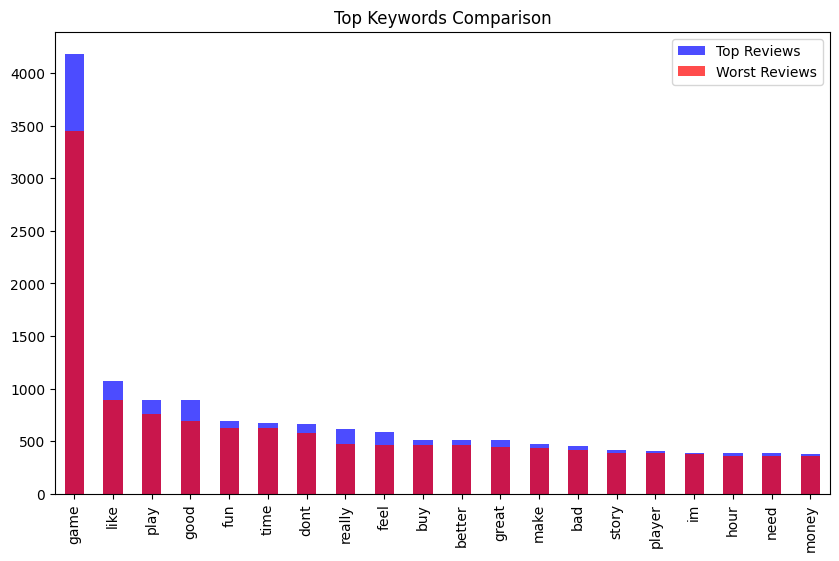

In [251]:
# Vizualizace klíčových slov

top_keywords_df = (
    pd.DataFrame(top_tfidf.toarray(), columns=top_keywords)
    .sum()
    .sort_values(ascending=False)
)
worst_keywords_df = (
    pd.DataFrame(worst_tfidf.toarray(), columns=worst_keywords)
    .sum()
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
top_keywords_df.head(20).plot(kind="bar", color="blue", alpha=0.7, label="Top Reviews")
worst_keywords_df.head(20).plot(
    kind="bar", color="red", alpha=0.7, label="Worst Reviews"
)
plt.title("Top Keywords Comparison")
plt.legend()
plt.show()

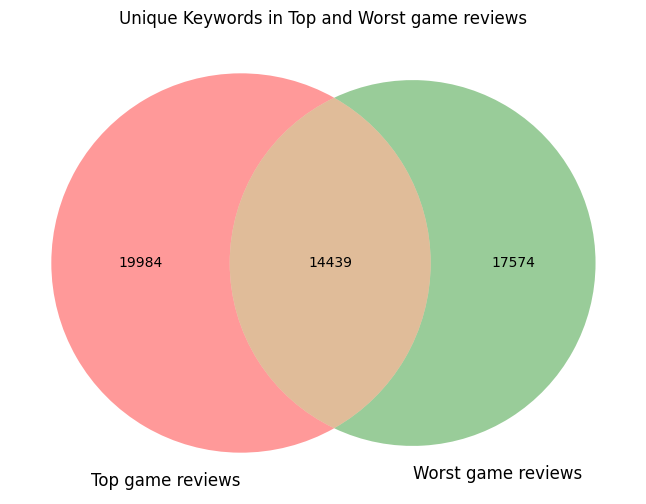

In [ ]:
# Zobrazení podobnosti klíčových slov

from sklearn.feature_extraction.text import CountVectorizer
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Vytvoření CountVectorizer objektu
vectorizer = CountVectorizer(stop_words="english")
top_X = vectorizer.fit_transform(top_game_reviews["cleaned_review"])
top_keywords = vectorizer.get_feature_names_out()

# Fit a transformace textových dat
vectorizer = CountVectorizer(stop_words="english")
worst_X = vectorizer.fit_transform(worst_game_reviews["cleaned_review"])
worst_keywords = vectorizer.get_feature_names_out()


# Unikátní klíčová slova pro každou skupinu
unique_top_keywords = set(top_keywords)
unique_worst_keywords = set(worst_keywords)


# Vennův diagram
plt.figure(figsize=(10, 6))
venn2(
    [unique_top_keywords, unique_worst_keywords],
    ("Top game reviews", "Worst game reviews"),
)
plt.title("Unique Keywords in Top and Worst game reviews")
plt.show()

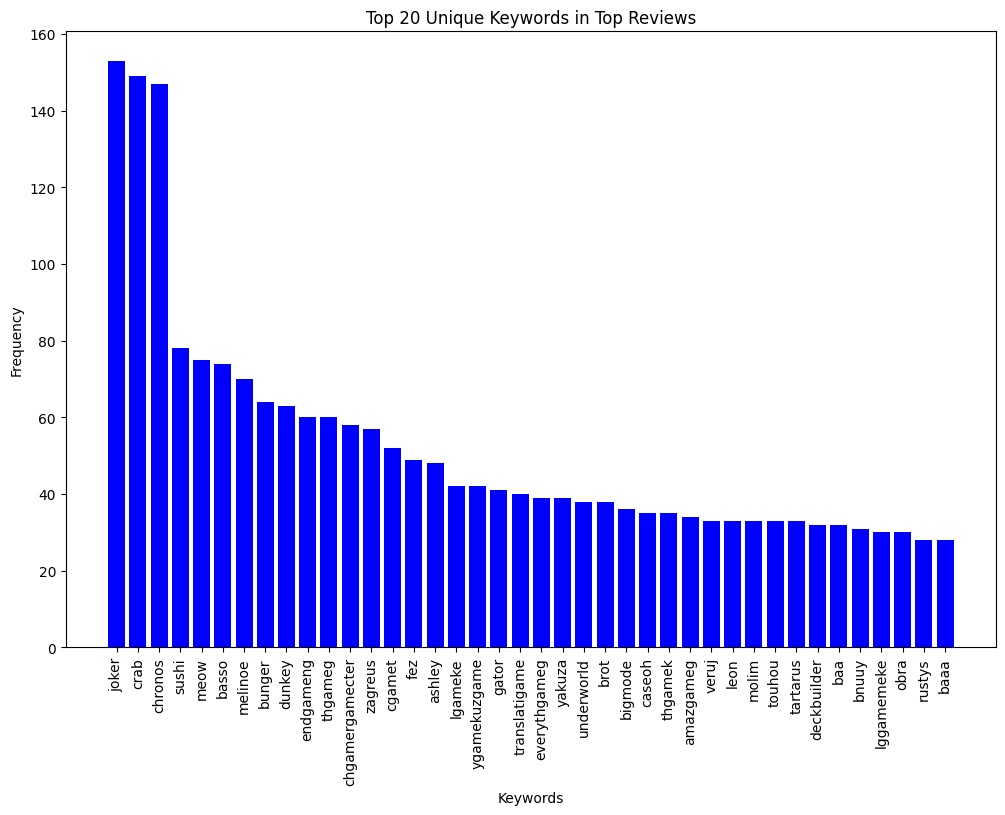

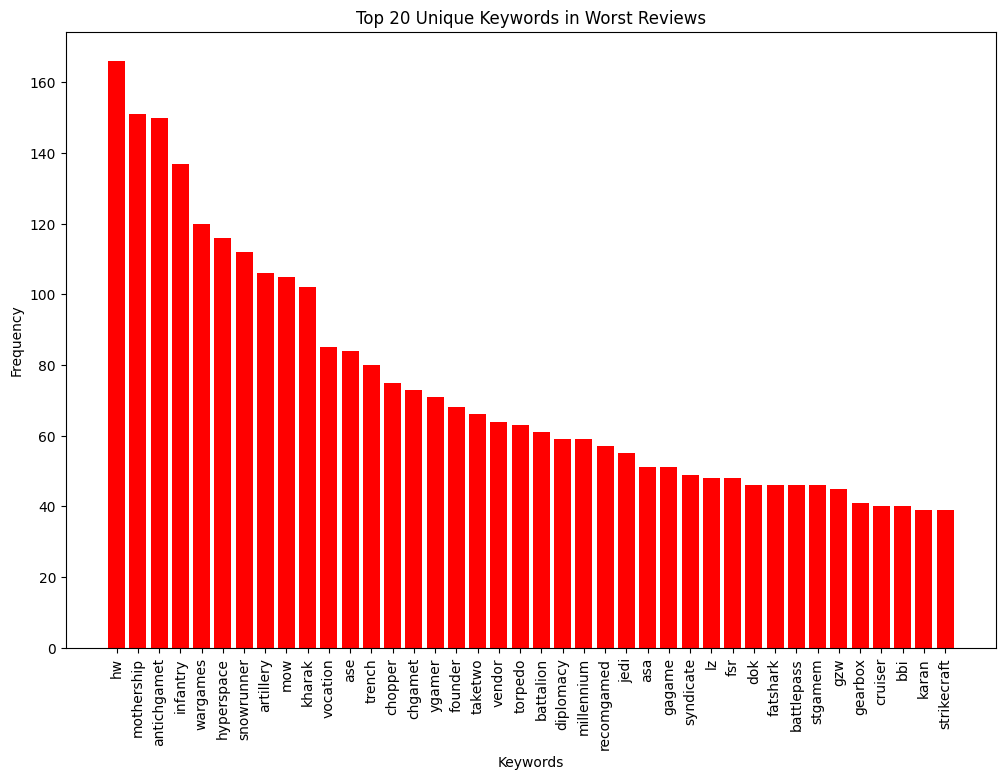

In [ ]:
# Zobrazení individuálních klíčových slov

from nltk import pos_tag
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


# Funkce pro odstranění vlastních jmen
def remove_proper_nouns(words):
    tagged_words = pos_tag(words)
    filtered_words = [
        word for word, tag in tagged_words if tag == "NN" or tag == "NNS" or tag == "VB"
    ]
    return filtered_words


# Vytvoření CountVectorizer objektu pro top recenze
vectorizer = CountVectorizer(stop_words="english")
top_X = vectorizer.fit_transform(top_game_reviews["cleaned_review"])
top_keywords = vectorizer.get_feature_names_out()
top_counts = top_X.sum(axis=0).A1

# Vytvoření CountVectorizer objektu pro worst recenze
vectorizer = CountVectorizer(stop_words="english")
worst_X = vectorizer.fit_transform(worst_game_reviews["cleaned_review"])
worst_keywords = vectorizer.get_feature_names_out()
worst_counts = worst_X.sum(axis=0).A1

# Unikátní klíčová slova pro každou skupinu
unique_top_keywords = set(top_keywords) - set(worst_keywords)
unique_worst_keywords = set(worst_keywords) - set(top_keywords)

# Četnosti unikátních klíčových slov pro každou skupinu
unique_top_counts = {
    word: top_counts[i]
    for i, word in enumerate(top_keywords)
    if word in unique_top_keywords
}
unique_worst_counts = {
    word: worst_counts[i]
    for i, word in enumerate(worst_keywords)
    if word in unique_worst_keywords
}

# Odstranění vlastních jmen z unikátních klíčových slov
unique_top_keywords_filtered = remove_proper_nouns(list(unique_top_counts.keys()))
unique_worst_keywords_filtered = remove_proper_nouns(list(unique_worst_counts.keys()))

# Četnosti filtrovanych unikátních klíčových slov
unique_top_counts_filtered = {
    word: unique_top_counts[word] for word in unique_top_keywords_filtered
}
unique_worst_counts_filtered = {
    word: unique_worst_counts[word] for word in unique_worst_keywords_filtered
}

# Převod na pandas DataFrame pro snadnou manipulaci a vizualizaci
top_unique_df_filtered = pd.DataFrame(
    list(unique_top_counts_filtered.items()), columns=["keyword", "count"]
).sort_values(by="count", ascending=False)
worst_unique_df_filtered = pd.DataFrame(
    list(unique_worst_counts_filtered.items()), columns=["keyword", "count"]
).sort_values(by="count", ascending=False)

# Vizualizace nejčastějších unikátních klíčových slov pro top recenze
plt.figure(figsize=(12, 8))
plt.bar(
    top_unique_df_filtered["keyword"].head(40),
    top_unique_df_filtered["count"].head(40),
    color="blue",
)
plt.title("Top 20 Unique Keywords in Top Reviews")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

# Vizualizace nejčastějších unikátních klíčových slov pro worst recenze
plt.figure(figsize=(12, 8))
plt.bar(
    worst_unique_df_filtered["keyword"].head(40),
    worst_unique_df_filtered["count"].head(40),
    color="red",
)
plt.title("Top 20 Unique Keywords in Worst Reviews")
plt.xlabel("Keywords")
plt.ylabel("Frequency")
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Implementace bag of Words (BoW)

from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Přidání sentimentálních štítků (1 pro pozitivní, 0 pro negativní)
top_game_reviews["sentiment"] = 1
worst_game_reviews["sentiment"] = 0

# Kombinace dat
all_reviews = pd.concat([top_game_reviews, worst_game_reviews])
X = all_reviews["cleaned_review"]
y = all_reviews["sentiment"]

# Bag-of-Words model

# Zvýšení počtu iterací pro logistickou regresi
# POZNÁMKA - bez použití max_iter_value byla hodnota Accuracy 0.8974, po přidání se zvýšila na 0.91084
# při testování jsem zjistil že bude stačit hodnota 2000, skutečný počet iterací byl cca 1963


bow_vectorizer = CountVectorizer(max_features=5000)  # Omezte na top 5000 slov
X_bow = bow_vectorizer.fit_transform(X)

# Rozdělení dat na trénovací a testovací sadu
X_train_bow, X_test_bow, y_train, y_test = train_test_split(
    X_bow, y, test_size=0.2, random_state=42
)

# Trénink modelu s BoW
model_bow = LogisticRegression(max_iter=MAX_ITER_VALUE)
model_bow.fit(X_train_bow, y_train)

# Predikce a vyhodnocení
y_pred_bow = model_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)

print("Accuracy with BoW:", accuracy_bow)


# Trénink modelu s BoW a škálováním
pipeline_bow = make_pipeline(
    StandardScaler(with_mean=False), LogisticRegression(max_iter=MAX_ITER_VALUE)
)
pipeline_bow.fit(X_train_bow, y_train)

# Predikce a vyhodnocení
y_pred_bow = pipeline_bow.predict(X_test_bow)
accuracy_bow = accuracy_score(y_test, y_pred_bow)
n_iter_bow = pipeline_bow.named_steps["logisticregression"].n_iter_[0]

print("Accuracy with BoW and StandardScaler:", accuracy_bow)
print("Number of iterations for BoW:", n_iter_bow)

Accuracy with BoW: 0.8509592516251784
Accuracy with BoW and StandardScaler: 0.8173458062470271
Number of iterations for BoW: 216


In [ ]:
# TF-IDF Model

# testování TF-IDF modelu při stejném počtu iterací
MAX_ITER_VALUE = 2000
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Omezte na top 5000 slov
X_tfidf = tfidf_vectorizer.fit_transform(X)

# Rozdělení dat na trénovací a testovací sadu
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)

# Trénink modelu s TF-IDF bez škálování
model_tfidf_no_scaling = LogisticRegression(max_iter=MAX_ITER_VALUE)
model_tfidf_no_scaling.fit(X_train_tfidf, y_train)

# Predikce a vyhodnocení
y_pred_tfidf_no_scaling = model_tfidf_no_scaling.predict(X_test_tfidf)
accuracy_tfidf_no_scaling = accuracy_score(y_test, y_pred_tfidf_no_scaling)
print("Accuracy with TF-IDF without StandardScaler:", accuracy_tfidf_no_scaling)

# Trénink modelu s TF-IDF a škálováním
pipeline_tfidf = make_pipeline(
    StandardScaler(with_mean=False), LogisticRegression(max_iter=MAX_ITER_VALUE)
)
pipeline_tfidf.fit(X_train_tfidf, y_train)

# Predikce a vyhodnocení
y_pred_tfidf = pipeline_tfidf.predict(X_test_tfidf)
accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
print("Accuracy with TF-IDF and StandardScaler:", accuracy_tfidf)

Accuracy with TF-IDF without StandardScaler: 0.8574599651181227
Accuracy with TF-IDF and StandardScaler: 0.804661487236404


In [ ]:
# Implementace Word-embeding

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


def get_word2vec_vector(text, model):
    word_vectors = [model.wv[word] for word in text if word in model.wv]
    if len(word_vectors) == 0:
        return np.zeros(model.vector_size)
    word_vectors = np.array(word_vectors).mean(axis=0)
    return word_vectors


# Trénování Word2Vec modelu
word2vec_model = Word2Vec(
    sentences=all_reviews_text, vector_size=100, window=5, min_count=2, workers=4
)
# Trénování Word2Vec modelu s různými parametry
# word2vec_model = Word2Vec(sentences=all_reviews_text, vector_size=200, window=10, min_count=5, workers=4)

# Uložení modelu
word2vec_model.save("word2vec.model")

# Vytvoření vektorů pro recenze
top_game_reviews["vector"] = top_game_reviews["cleaned_review"].apply(
    lambda x: get_word2vec_vector(x, word2vec_model)
)
worst_game_reviews["vector"] = worst_game_reviews["cleaned_review"].apply(
    lambda x: get_word2vec_vector(x, word2vec_model)
)

# Kombinace vektorů a sentimentů
all_vectors = np.vstack(
    (
        np.stack(top_game_reviews["vector"].values),
        np.stack(worst_game_reviews["vector"].values),
    )
)
all_sentiments = np.hstack(
    (np.ones(len(top_game_reviews)), np.zeros(len(worst_game_reviews)))
)
# Rozdělení dat na trénovací a testovací sadu

X_train, X_test, y_train, y_test = train_test_split(
    all_vectors, all_sentiments, test_size=0.2, random_state=42
)

# Trénink modelu s Word2Vec
model_w2v = LogisticRegression(max_iter=MAX_ITER_VALUE)
model_w2v.fit(X_train, y_train)

# Predikce a vyhodnocení
y_pred_w2v = model_w2v.predict(X_test)
accuracy_w2v = accuracy_score(y_test, y_pred_w2v)
print("Accuracy with Word2Vec:", accuracy_w2v)


# GloVe nepřineslo lepší výsledek. Stále se pohybujeme kolem 0.8308
## Použití GloVe modelu pro vytvoření vektorů
# glove_model = api.load("glove-wiki-gigaword-100")
# top_game_reviews['vector'] = top_game_reviews['cleaned_review'].apply(lambda x: get_glove_vector(x, glove_model))
# worst_game_reviews['vector'] = worst_game_reviews['cleaned_review'].apply(lambda x: get_glove_vector(x, glove_model))
#
## Kombinace vektorů a sentimentů
# all_vectors = np.vstack((np.stack(top_game_reviews['vector'].values), np.stack(worst_game_reviews['vector'].values)))
# all_sentiments = np.hstack((np.ones(len(top_game_reviews)), np.zeros(len(worst_game_reviews))))
#
## Rozdělení dat na trénovací a testovací sadu
# X_train, X_test, y_train, y_test = train_test_split(all_vectors, all_sentiments, test_size=0.2, random_state=42)
#
## Trénink modelu s GloVe
# model_glove = LogisticRegression(max_iter=1000)
# model_glove.fit(X_train, y_train)
#
## Predikce a vyhodnocení
# y_pred_glove = model_glove.predict(X_test)
# accuracy_glove = accuracy_score(y_test, y_pred_glove)
# print("Accuracy with GloVe:", accuracy_glove)

Accuracy with Word2Vec: 0.583003012525765


Average sentiment for top game reviews: 0.413953863369328
Average sentiment for worst game reviews: 0.20601249816957098


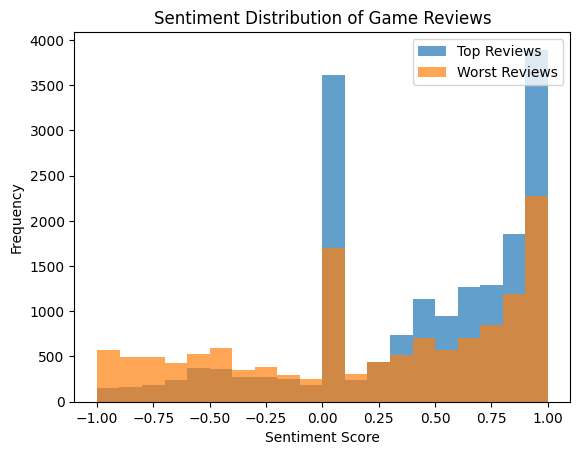

Sentiment distribution for top game reviews:
 sentiment_category
Very Positive    0.517596
Neutral          0.186594
Positive         0.158619
Negative         0.075589
Very Negative    0.061601
Name: proportion, dtype: float64
Sentiment distribution for worst game reviews:
 sentiment_category
Very Positive    0.409138
Very Negative    0.184288
Positive         0.166349
Negative         0.138088
Neutral          0.102138
Name: proportion, dtype: float64


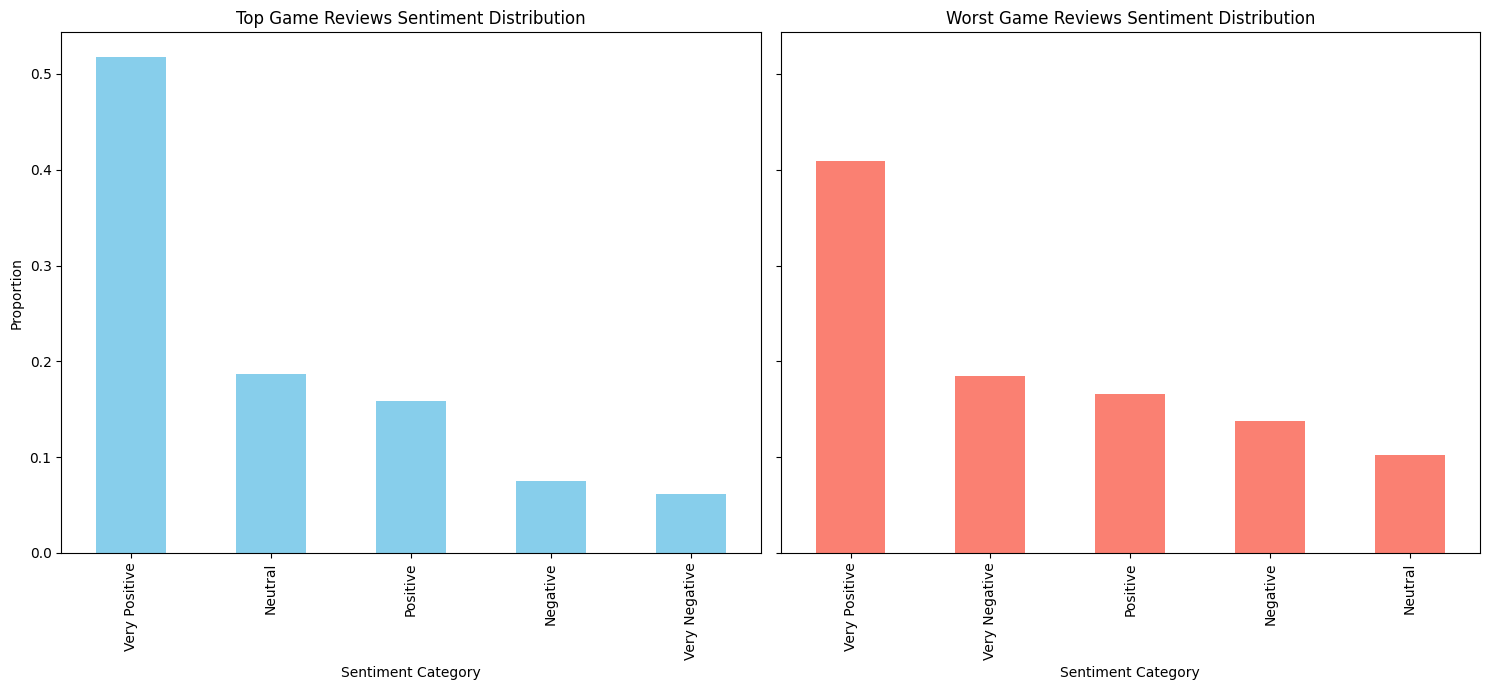

In [ ]:
# Analýza sentimentu:


# Inicializace VADER analyzátoru
analyzer = SentimentIntensityAnalyzer()


def analyze_sentiment(text):
    vs = analyzer.polarity_scores(text)
    return vs["compound"]


# Analýza sentimentu pro nejlepší a nejhorší recenze
top_game_reviews["sentiment"] = top_game_reviews["cleaned_review"].apply(
    analyze_sentiment
)
worst_game_reviews["sentiment"] = worst_game_reviews["cleaned_review"].apply(
    analyze_sentiment
)

# Výpočet průměrného sentimentu
average_top_sentiment = top_game_reviews["sentiment"].mean()
average_worst_sentiment = worst_game_reviews["sentiment"].mean()

print("Average sentiment for top game reviews:", average_top_sentiment)
print("Average sentiment for worst game reviews:", average_worst_sentiment)

# Vizualizace sentimentu
import matplotlib.pyplot as plt

plt.hist(top_game_reviews["sentiment"], bins=20, alpha=0.7, label="Top Reviews")
plt.hist(worst_game_reviews["sentiment"], bins=20, alpha=0.7, label="Worst Reviews")
plt.legend(loc="upper right")
plt.title("Sentiment Distribution of Game Reviews")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()


# Kategorizace sentimentu
def categorize_sentiment(score):
    if score < -0.5:
        return "Very Negative"
    elif -0.5 <= score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    elif 0 < score <= 0.5:
        return "Positive"
    else:
        return "Very Positive"


top_game_reviews["sentiment_category"] = top_game_reviews["sentiment"].apply(
    categorize_sentiment
)
worst_game_reviews["sentiment_category"] = worst_game_reviews["sentiment"].apply(
    categorize_sentiment
)

# Výpočet distribuce sentimentu
top_sentiment_distribution = top_game_reviews["sentiment_category"].value_counts(
    normalize=True
)
worst_sentiment_distribution = worst_game_reviews["sentiment_category"].value_counts(
    normalize=True
)

print("Sentiment distribution for top game reviews:\n", top_sentiment_distribution)
print("Sentiment distribution for worst game reviews:\n", worst_sentiment_distribution)

# Vizualizace distribuce sentimentu
fig, ax = plt.subplots(1, 2, figsize=(15, 7), sharey=True)

top_sentiment_distribution.plot(
    kind="bar",
    ax=ax[0],
    color="skyblue",
    title="Top Game Reviews Sentiment Distribution",
)
worst_sentiment_distribution.plot(
    kind="bar",
    ax=ax[1],
    color="salmon",
    title="Worst Game Reviews Sentiment Distribution",
)

ax[0].set_ylabel("Proportion")
ax[0].set_xlabel("Sentiment Category")
ax[1].set_xlabel("Sentiment Category")

plt.tight_layout()
plt.show()